In [3]:
# Importing the libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\Luiza\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\Luiza\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# Importing the dataset
df_salario = pd.read_csv('dataset\salario.csv')

In [5]:
# Visualizing info
df_salario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempo_na_empresa  1000 non-null   int64  
 1   nivel_na_empresa  1000 non-null   int64  
 2   salario_em_reais  1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [6]:
# Copy the dataset
df_salario_eda = df_salario.copy()
df_salario_bucketing = df_salario.copy()

## EDA

In [7]:
# Visualizing the dataset
df_salario_eda.head()

,tempo_na_empresa,nivel_na_empresa,salario_em_reais
0,50,1,2288.13
1,49,4,2389.84
2,39,10,2158.73
3,51,1,2341.06
4,62,7,3584.20


<AxesSubplot:xlabel='tempo_na_empresa'>

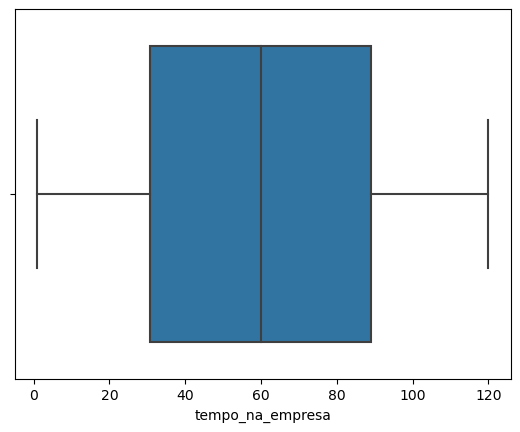

In [8]:
# Checking for outliers
sns.boxplot(data=df_salario_eda, x='tempo_na_empresa')

<AxesSubplot:xlabel='nivel_na_empresa'>

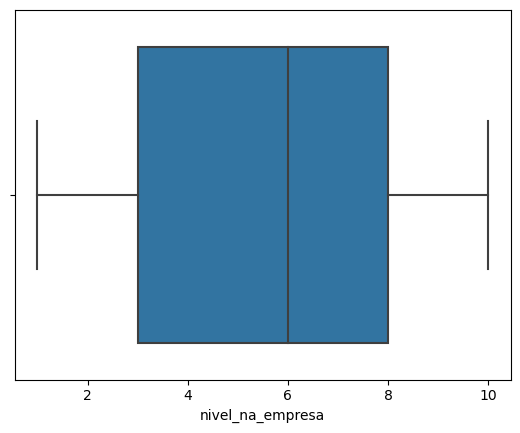

In [9]:
# Checking for outliers
sns.boxplot(data=df_salario_eda, x='nivel_na_empresa')

<AxesSubplot:xlabel='salario_em_reais'>

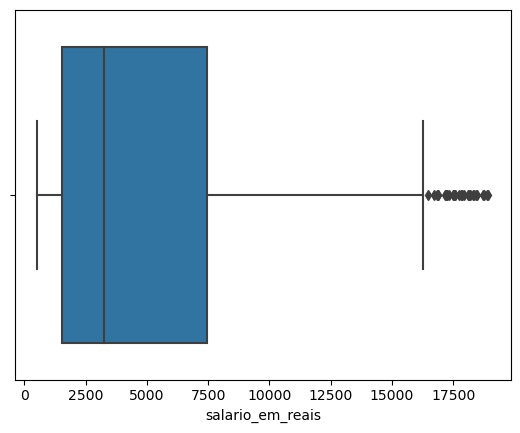

In [10]:
# Checking for outliers, but these are normal 
sns.boxplot(data=df_salario_eda, x='salario_em_reais')

<AxesSubplot:xlabel='tempo_na_empresa', ylabel='salario_em_reais'>

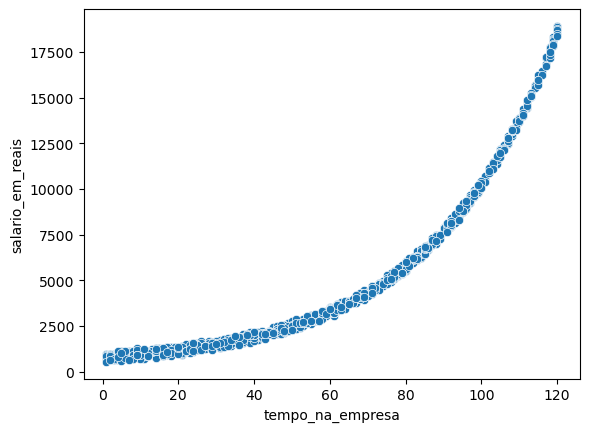

In [11]:
# Crossing numerical variables with salary in reais (dependent variable)
sns.scatterplot(data=df_salario_eda, x='tempo_na_empresa', y='salario_em_reais')

<AxesSubplot:xlabel='nivel_na_empresa', ylabel='salario_em_reais'>

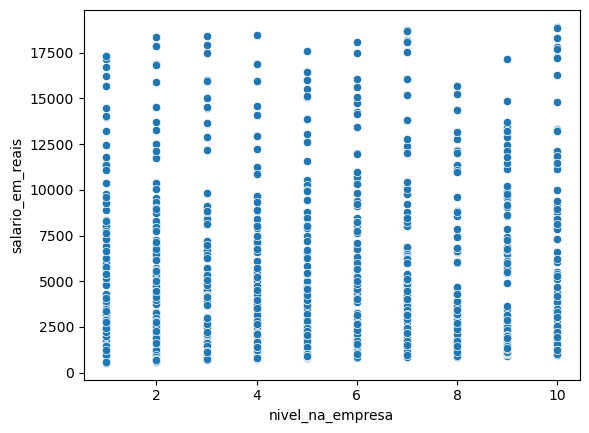

In [12]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='salario_em_reais')

<AxesSubplot:xlabel='nivel_na_empresa', ylabel='tempo_na_empresa'>

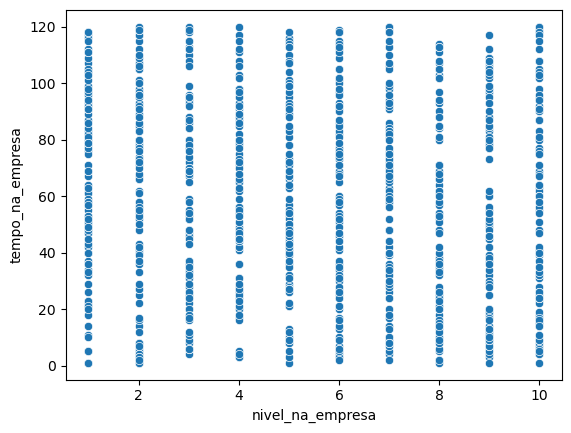

In [13]:
sns.scatterplot(data=df_salario_eda, x='nivel_na_empresa', y='tempo_na_empresa')

<AxesSubplot:>

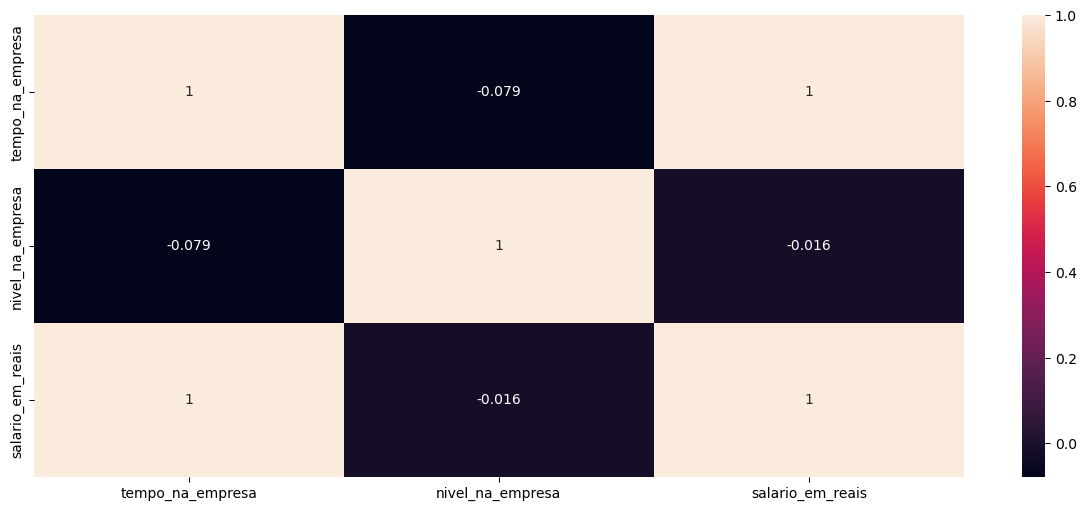

In [14]:
# Heatmap of the correlation 
plt.figure(figsize=(15, 6))
sns.heatmap(df_salario_eda.corr('spearman'), annot=True)

<AxesSubplot:>

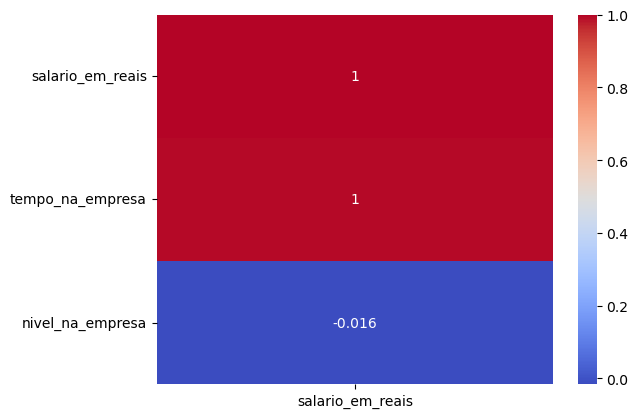

In [15]:
# Heatmap of the correlation 
sns.heatmap(df_salario_eda.corr('spearman')[['salario_em_reais']].sort_values(by='salario_em_reais', ascending=False), annot=True, cmap='coolwarm')

In [16]:
# Bucketing
bins_tempo_casa = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130]
labels_tempo_casa = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119', '120-129']
df_salario_bucketing['escala_tempo'] = pd.cut(x=df_salario_bucketing['tempo_na_empresa'], bins=bins_tempo_casa, labels=labels_tempo_casa, include_lowest=True)

c:\Users\Luiza\anaconda3\lib\site-packages\seaborn\categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<AxesSubplot:xlabel='escala_tempo', ylabel='salario_em_reais'>

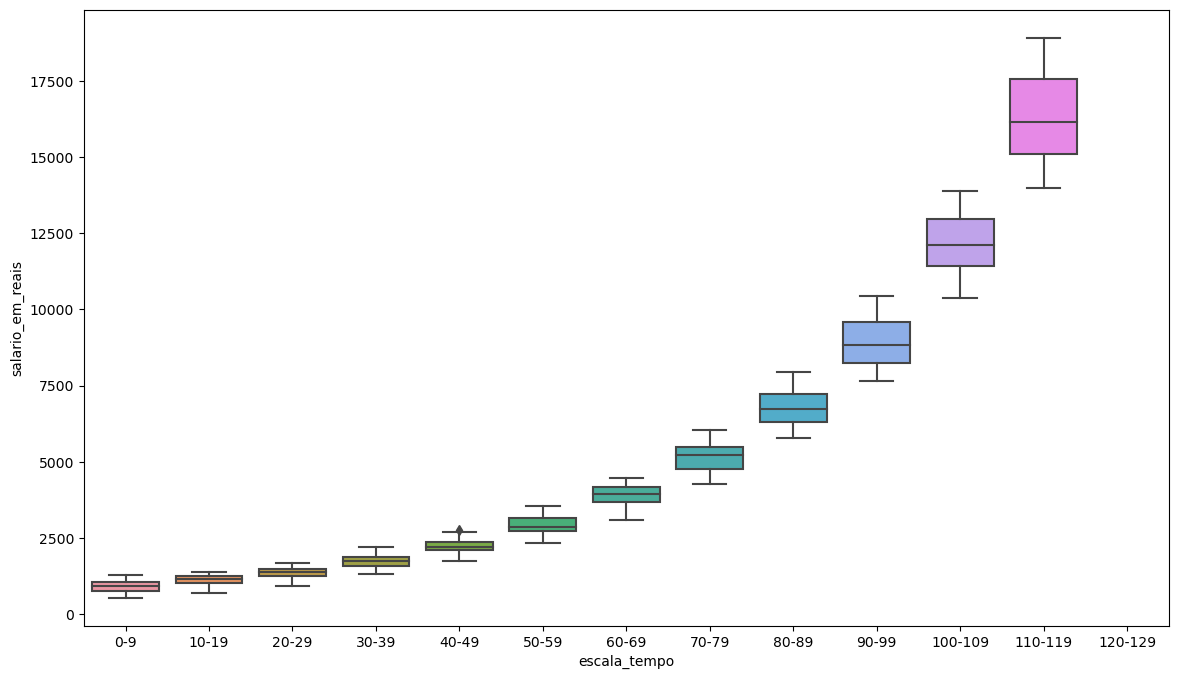

In [17]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_salario_bucketing, x='escala_tempo', y='salario_em_reais')  

## Modelo Linear

In [18]:
# Importing the libraries
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np

In [19]:
# Defining the X and y
X = df_salario.drop(columns=['salario_em_reais'], axis=1)
y = df_salario['salario_em_reais']

In [20]:
# Configures a k-fold cross validation with 5 splits.
# The data is shuffled (shuffle=True) before being divided into k groups.
# The random seed is set to 51 (random_state=51) to ensure reproducibility of results.
kf = KFold(n_splits=5, shuffle=True, random_state=51)

In [21]:
# Block of code to train the model

# Pipeline 
# Standardize numerical variables - tempo_na_empresa, nivel_na_empresa

# Name of numerical columns
colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

# Transformer for numerical variables
transformer_numericas = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pre-processor
preprocessor = ColumnTransformer(transformers=[
    ('num', transformer_numericas, colunas_numericas)
])

# Pipeline
model_reg = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])

# Store RMSE training and testing
rmse_score_fold_train = []
rmse_score_fold_test = []

# Store R2 testing
r2_score_fold_test = []

# Residuos
residuos = []

# Store predictions
y_pred_total = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_reg.fit(X_train, y_train)

    # Predictions
    y_train_pred = model_reg.predict(X_train)
    y_test_pred = model_reg.predict(X_test)

    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    r2score_test = r2_score(y_test, y_test_pred)
    residuos_test = np.array(y_test - y_test_pred)

    rmse_score_fold_train.append(rmse_train)
    rmse_score_fold_test.append(rmse_test)
    r2_score_fold_test.append(r2score_test)
    residuos.append(residuos_test)
    y_pred_total.append(y_test_pred)


rmse_train_final = np.mean(rmse_score_fold_train)
rmse_test_final = np.mean(rmse_score_fold_test)
r2_test_final = np.mean(r2_score_fold_test)
percentual_rmse = (rmse_test_final - rmse_train_final) / rmse_train_final * 100
residuos = np.array(residuos).reshape(-1)
y_pred_total = np.array(y_pred_total).reshape(-1)
    

## Métricas do modelo Linear

In [22]:
# Print the results
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'Percentual diferença entre treino e teste RMSE: {percentual_rmse}')
print(f'R2 Teste: {r2_test_final}')


RMSE Treino: 1882.8318426651392
RMSE Teste: 1886.4504221336076
Percentual diferença entre treino e teste RMSE: 0.19218813844503052
R2 Teste: 0.8261178870584761


## Análise de residuos - Modelo Linear

In [23]:
# Residuos
from scipy.stats import zscore
residuos_zscore = zscore(residuos)

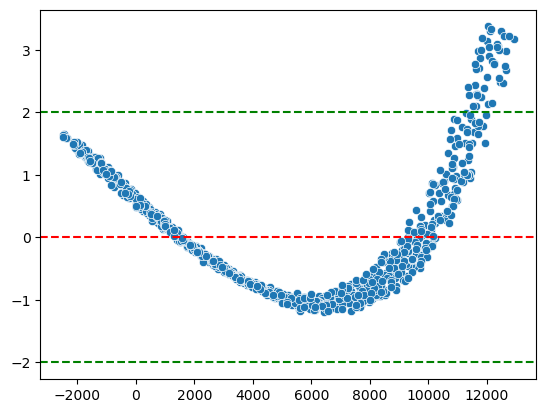

In [24]:
# Check linearity of residuals Values ​​between -2 and 2
# Check homoscedasticity of residuals: Values ​​around the straight line
sns.scatterplot(x=y_pred_total, y=residuos_zscore)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=2, color='g', linestyle='--')
plt.axhline(y=-2, color='g', linestyle='--')    

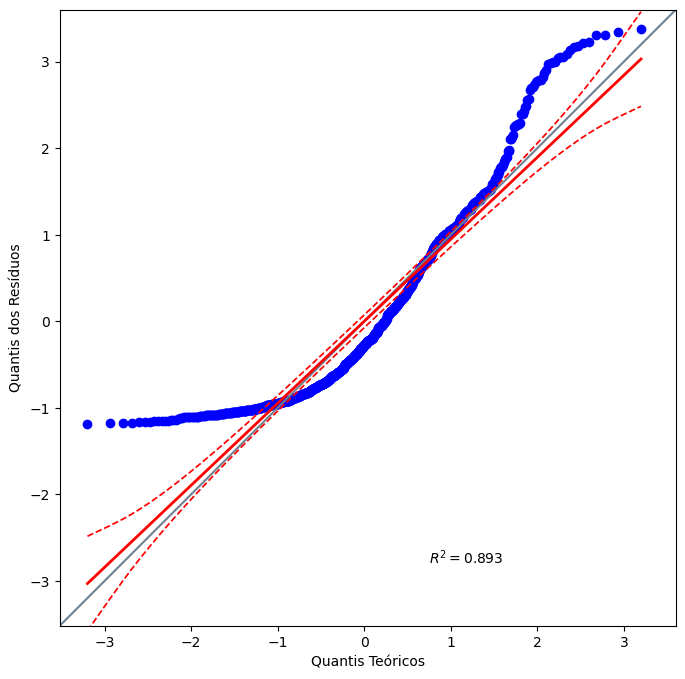

In [25]:
# Normality of residuals
import pingouin as pg
plt.figure(figsize=(14, 8))
pg.qqplot(residuos_zscore, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis dos Resíduos')
plt.show()

In [26]:
# Normality test
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors
stat_shapiro, p_shapiro = shapiro(residuos)
print(f'Shapiro: {stat_shapiro}, {p_shapiro}')

Shapiro: 0.891970157623291, 7.015059614730555e-26


In [27]:
stat_kstest, p_kstest = kstest(residuos, 'norm')
print(f'Kstest: {stat_kstest}, {p_kstest}')

Kstest: 0.5939999999999955, 0.0


In [28]:
stat_lilliefors, p_lilliefors = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Lilliefors: {stat_lilliefors}, {p_lilliefors}')

Lilliefors: 0.11825983774680088, 0.0009999999999998899


## Modelo Polinomial 

In [30]:
# Importing the libraries
from sklearn.preprocessing import PolynomialFeatures

# Polynomial Features
feat_poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = feat_poly.fit_transform(X)
feat_poly.feature_names_in_

array(['tempo_na_empresa', 'nivel_na_empresa'], dtype=object)

In [31]:
feat_poly.get_feature_names_out(feat_poly.feature_names_in_)

array(['tempo_na_empresa', 'nivel_na_empresa', 'tempo_na_empresa^2',
       'tempo_na_empresa nivel_na_empresa', 'nivel_na_empresa^2',
       'tempo_na_empresa^3', 'tempo_na_empresa^2 nivel_na_empresa',
       'tempo_na_empresa nivel_na_empresa^2', 'nivel_na_empresa^3'],
      dtype=object)

In [37]:
# Block of code to train the model with polynomial features

#graus_polymonial = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
graus_polymonial = [4]

rmse_train_values = []
rmse_test_values = []
r2_test_values = []
percentual_rmse_values = []

kf = KFold(n_splits=5, shuffle=True, random_state=51)

for grau in graus_polymonial:
    # Pipeline 
    # Standardize numerical variables - tempo_na_empresa, nivel_na_empresa

    # Name of numerical columns
    colunas_numericas = ['tempo_na_empresa', 'nivel_na_empresa']

    # Transformer for numerical variables
    transformer_numericas = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # Pre-processor
    preprocessor = ColumnTransformer(transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ])

    poly_features = PolynomialFeatures(degree=grau, include_bias=False)

    model_poly = Pipeline(steps=[('preprocessor', preprocessor), 
                                 ('poly_features', poly_features),
                                 ('regressor', LinearRegression())])

    # Store RMSE training and testing
    rmse_score_fold_train = []
    rmse_score_fold_test = []

    # Store R2 testing
    r2_score_fold_test = []

    # Residuos
    residuos = []

    # Store predictions
    y_pred_total = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model_poly.fit(X_train, y_train)

        # Predictions
        y_train_pred = model_poly.predict(X_train)
        y_test_pred = model_poly.predict(X_test)

        rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
        rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
        r2score_test = r2_score(y_test, y_test_pred)
        residuos_test = np.array(y_test - y_test_pred)

        rmse_score_fold_train.append(rmse_train)
        rmse_score_fold_test.append(rmse_test)
        r2_score_fold_test.append(r2score_test)
        residuos.append(residuos_test)
        y_pred_total.append(y_test_pred)


    rmse_train_final = np.mean(rmse_score_fold_train)
    rmse_test_final = np.mean(rmse_score_fold_test)
    r2_test_final = np.mean(r2_score_fold_test)
    percentual_rmse = (rmse_test_final - rmse_train_final) / rmse_train_final * 100
    residuos = np.array(residuos).reshape(-1)
    y_pred_total = np.array(y_pred_total).reshape(-1)

    rmse_train_values.append(rmse_train_final)
    rmse_test_values.append(rmse_test_final)
    r2_test_values.append(r2_test_final)
    percentual_rmse_values.append(percentual_rmse)
    

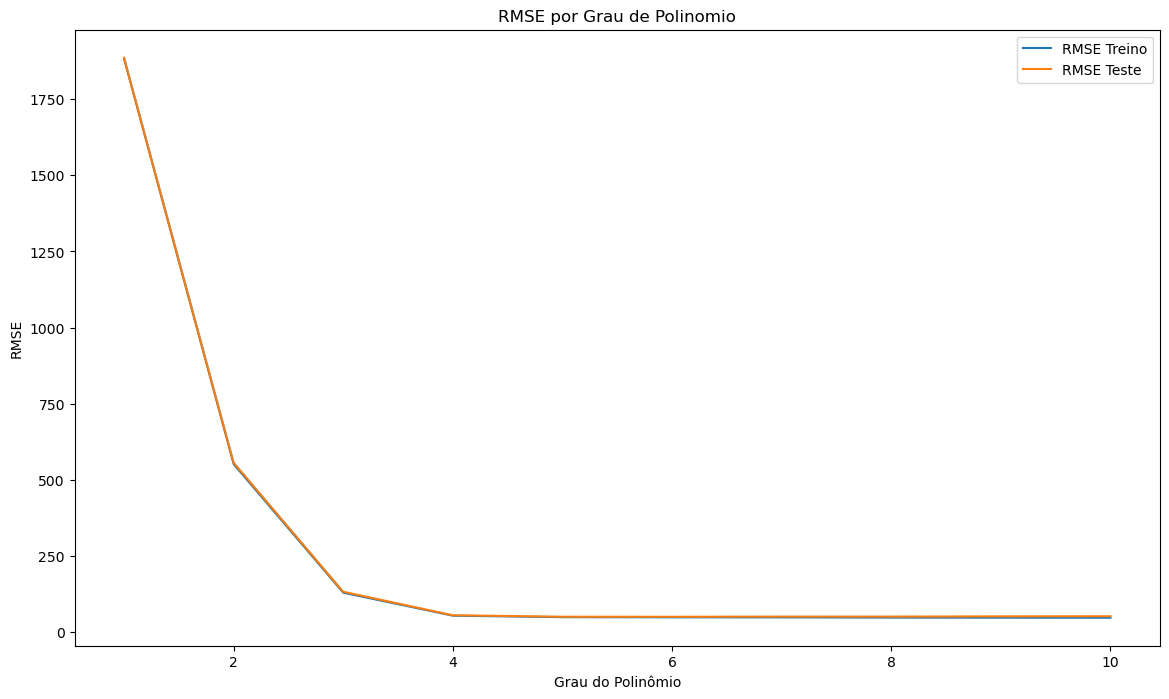

In [35]:
plt.figure(figsize=(14, 8))
plt.plot(graus_polymonial, rmse_train_values, label='RMSE Treino')
plt.plot(graus_polymonial, rmse_test_values, label='RMSE Teste')
plt.xlabel('Grau do Polinômio')
plt.ylabel('RMSE')
plt.title('RMSE por Grau de Polinomio')
plt.legend()
plt.show()

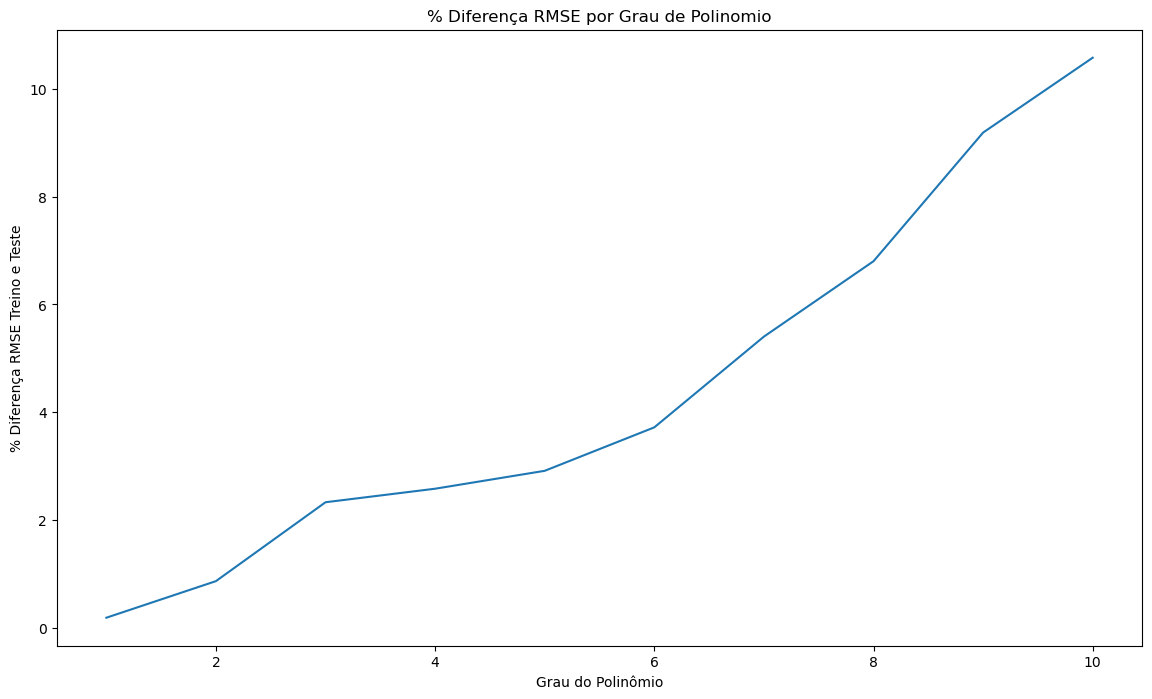

In [36]:
# Percentual
plt.figure(figsize=(14, 8))
plt.plot(graus_polymonial, percentual_rmse_values, label='Percentual RMSE')
plt.xlabel('Grau do Polinômio')
plt.ylabel('% Diferença RMSE Treino e Teste')
plt.title('% Diferença RMSE por Grau de Polinomio')
plt.show()

## Métricas do Modelo Polinomial

In [38]:
# Print the results
print(f'RMSE Treino: {rmse_train_final}')
print(f'RMSE Teste: {rmse_test_final}')
print(f'Percentual diferença entre treino e teste RMSE: {percentual_rmse}')
print(f'R2 Teste: {r2_test_final}')

RMSE Treino: 53.32698559565159
RMSE Teste: 54.70504352796327
Percentual diferença entre treino e teste RMSE: 2.5841661907551114
R2 Teste: 0.9998524123039415


## Análise de residuos - Modelo Polinomial

In [39]:
# Residuos
from scipy.stats import zscore
residuos_zscore = zscore(residuos)

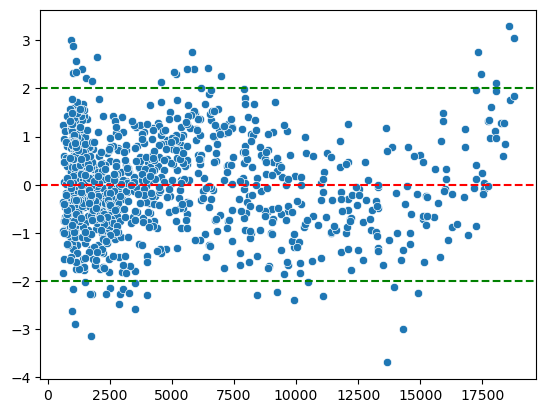

In [40]:
# Check linearity of residuals Values ​​between -2 and 2
# Check homoscedasticity of residuals: Values ​​around the straight line
sns.scatterplot(x=y_pred_total, y=residuos_zscore)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=2, color='g', linestyle='--')
plt.axhline(y=-2, color='g', linestyle='--')    

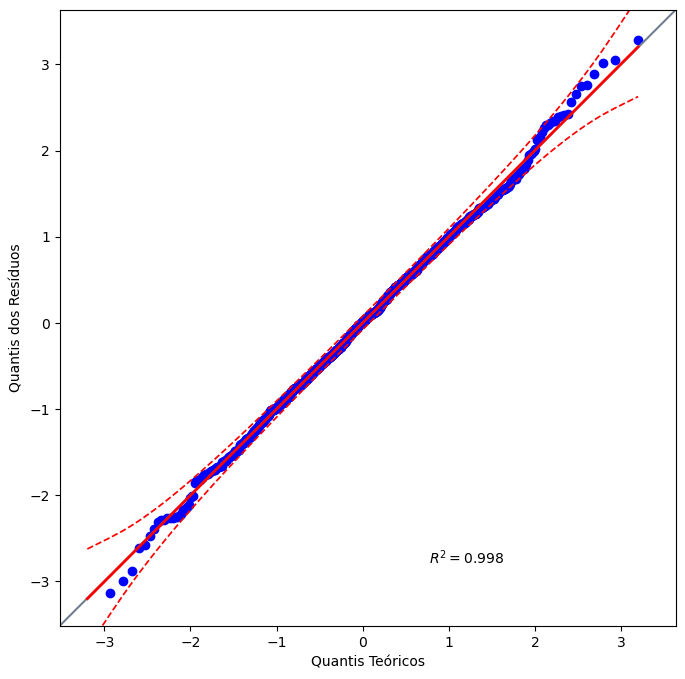

In [41]:

import pingouin as pg
plt.figure(figsize=(14, 8))
pg.qqplot(residuos_zscore, dist='norm', confidence=0.95)
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis dos Resíduos')
plt.show()

In [42]:
# Normality test
from scipy.stats import shapiro, kstest
from statsmodels.stats.diagnostic import lilliefors
stat_shapiro, p_shapiro = shapiro(residuos)
print(f'Shapiro: {stat_shapiro}, {p_shapiro}')

Shapiro: 0.9986947774887085, 0.6850231289863586


In [43]:
stat_kstest, p_kstest = kstest(residuos, 'norm')
print(f'Kstest: {stat_kstest}, {p_kstest}')

Kstest: 0.48237446499537606, 1.2202460104731364e-214


In [44]:
stat_lilliefors, p_lilliefors = lilliefors(residuos, dist='norm', pvalmethod='table')
print(f'Lilliefors: {stat_lilliefors}, {p_lilliefors}')

Lilliefors: 0.013637346894983415, 0.9566270022045138


## Predição individual

In [48]:
# Test the model
input_features = {
    'tempo_na_empresa': 72,
    'nivel_na_empresa': 10
}

pred_df = pd.DataFrame(input_features, index=[1])

In [49]:
pred_df.head()

,tempo_na_empresa,nivel_na_empresa
1,72,10


In [50]:
model_poly.predict(pred_df)

array([4808.03154228])

In [51]:
# Save the model
import joblib

joblib.dump(model_poly, 'model_salario.pkl')

['model_salario.pkl']